In [1]:
from wflow import wflow_bmi

import os
import time
import datetime
import pandas as pd
import xarray as xr

import hydrostats.data as hd
import hydrostats.visual as hv
import matplotlib.pyplot as plt

import HydroErr as he
import numpy as np

In [2]:
#Set working directory
os.chdir("C:\Users\jerom\Desktop\wflow\examples\wflow_rhine_sbm") 

In [3]:
#Call BMI and initialize configuration file
wflow = wflow_bmi.wflowbmi_csdms()
wflow.initialize("wflow_sbm.ini")

2018-10-08 14:08:13,506 - wflow_sbm.ini - pcrut - DEBUG - File logging to C:\Users\jerom\Desktop\wflow\examples\wflow_rhine_sbm\run_default\wflow.log
2018-10-08 14:08:13,513 - wflow_sbm.ini - wf_DynamicFramework - INFO - wflow_sbm.ini 0+unknown Case: C:\Users\jerom\Desktop\wflow\examples\wflow_rhine_sbm Runid: run_default
2018-10-08 14:08:13,516 - wflow_sbm.ini - wf_DynamicFramework - INFO - Initialise framework version: 0+unknown
2018-10-08 14:08:13,520 - wflow_sbm.ini - wf_DynamicFramework - WARNING - Ini file made for sbm but found wflow.wflow_sbm in code.
2018-10-08 14:08:13,528 - wflow_sbm.ini - wf_DynamicFramework - INFO - Adding csv output at C:\Users\jerom\Desktop\wflow\examples\wflow_rhine_sbm\staticmaps/wflow_landuse.map function: average
2018-10-08 14:08:13,532 - wflow_sbm.ini - wf_DynamicFramework - INFO - Adding csv output at C:\Users\jerom\Desktop\wflow\examples\wflow_rhine_sbm\staticmaps/wflow_subcatch.map function: average
2018-10-08 14:08:13,536 - wflow_sbm.ini - wf_Dy

2018-10-08 14:08:13,740 - wflow_sbm.ini - wf_DynamicFramework - INFO - Creating map from table: C:\Users\jerom\Desktop\wflow\examples\wflow_rhine_sbm/intbl/KsatVer.tbl
2018-10-08 14:08:13,743 - wflow_sbm.ini - wf_DynamicFramework - WARNING - tbl file not found (C:\Users\jerom\Desktop\wflow\examples\wflow_rhine_sbm/intbl/MporeFrac.tbl) returning default value: 0.0
2018-10-08 14:08:13,749 - wflow_sbm.ini - wf_DynamicFramework - WARNING - tbl file not found (C:\Users\jerom\Desktop\wflow\examples\wflow_rhine_sbm/intbl/KsatHorFrac.tbl) returning default value: 1.0
2018-10-08 14:08:13,756 - wflow_sbm.ini - wf_DynamicFramework - INFO - Creating map from table: C:\Users\jerom\Desktop\wflow\examples\wflow_rhine_sbm/intbl/M.tbl
2018-10-08 14:08:13,763 - wflow_sbm.ini - wf_DynamicFramework - INFO - Creating map from table: C:\Users\jerom\Desktop\wflow\examples\wflow_rhine_sbm/intbl/N.tbl
2018-10-08 14:08:13,770 - wflow_sbm.ini - wf_DynamicFramework - INFO - Creating map from table: C:\Users\jerom

In [4]:
wflow.get_input_var_names()

['CanopyStorage',
 'FirstZoneDepth',
 'LowerZoneStorage',
 'Snow',
 'SnowWater',
 'SurfaceRunoff',
 'SurfaceRunoffDyn',
 'TSoil',
 'UStoreDepth',
 'WaterLevel',
 'WaterLevelDyn',
 'InwaterMM',
 'IF']

In [5]:
wflow.get_attribute_names()

['inputmapstacks:Precipitation',
 'inputmapstacks:EvapoTranspiration',
 'inputmapstacks:Temperature',
 'inputmapstacks:Inflow',
 'run:starttime',
 'run:endtime',
 'run:runinfo',
 'run:timestepsecs',
 'run:reinit',
 'run:runlengthdetermination',
 'model:modeltype',
 'model:AnnualDischarge',
 'model:Alpha',
 'model:ModelSnow',
 'model:ScalarInput',
 'model:InterpolationMethod',
 'model:WIMaxScale',
 'model:Tslice',
 'model:UpdMaxDist',
 'model:origTopogLateral',
 'model:configfile',
 'model:reinit',
 'model:fewsrun',
 'model:OverWriteInit',
 'model:updating',
 'model:updateFile',
 'model:lateralmethod',
 'model:sCatch',
 'model:intbl',
 'model:timestepsecs',
 'model:MaxUpdMult',
 'model:MinUpdMult',
 'model:UpFrac',
 'model:waterdem',
 'model:reInfilt',
 'model:MassWasting',
 'model:wflow_subcatch',
 'model:wflow_dem',
 'model:wflow_ldd',
 'model:wflow_river',
 'model:wflow_riverlength',
 'model:wflow_riverlength_fact',
 'model:wflow_landuse',
 'model:wflow_soil',
 'model:wflow_gauges',


In [6]:
#List of output variables
wflow.get_output_var_names()

['CanopyStorage',
 'FirstZoneDepth',
 'LowerZoneStorage',
 'Snow',
 'SnowWater',
 'SurfaceRunoff',
 'SurfaceRunoffDyn',
 'TSoil',
 'UStoreDepth',
 'WaterLevel',
 'WaterLevelDyn',
 'PotTransSoil',
 'Transpiration',
 'ActEvapOpenWater',
 'soilevap',
 'Interception',
 'ActEvap',
 'SurfaceRunoffCatchmentMM',
 'ExcessWater',
 'InfiltExcess',
 'ActInfilt',
 'zi',
 'Transfer',
 'CapFlux',
 'RunoffCoeff',
 'InwaterMM']

In [7]:
#Set output variable name(s)
variable = "SurfaceRunoff" 

In [8]:
#Get lon/lat for xarray
lon = wflow.get_grid_x(variable) 
lat = wflow.get_grid_y(variable)

In [9]:
#Create 1D Lon/Lat lists for xarray
lon2 = lon[0,:]
lat2 = lat[:,0]

In [10]:
#Get time step, start, end and calculate the amount of model time steps
tstep = wflow.get_time_step()
tstart = wflow.get_start_time()
tend = wflow.get_end_time()

tstep_nmbr = ((tend - tstart)/tstep) + 1

print tstep_nmbr
print time.ctime(int(tstart)) + " start"
print time.ctime(int(tend)) + " end"

365
Sun Jan  1 01:00:00 1995 start
Sun Dec 31 01:00:00 1995 end


In [11]:
#Set correct date format that would work for all models
date_start = datetime.datetime.strptime(time.ctime(int(tstart)), "%a %b %d %H:%M:%S %Y").strftime('%Y-%m-%d')

In [12]:
#Create xarray dataset with coordinates and time series
ds = xr.Dataset(coords={'lon': lon2,
                        'lat': lat2,
                        'time': pd.date_range(date_start,  periods = tstep_nmbr)})
ds

<xarray.Dataset>
Dimensions:  (lat: 169, lon: 187, time: 365)
Coordinates:
  * lat      (lat) float32 45.894268 45.930935 45.9676 ... 52.0176 52.054268
  * lon      (lon) float32 5.2271633 5.26383 5.3004966 ... 12.010497 12.047163
  * time     (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
Data variables:
    *empty*

In [13]:
#Create empty array for faster filling
data_variable = np.zeros(shape=(tstep_nmbr, len(lat2), len(lon2)))

In [14]:
#Model run with retrieval of variables for each time step
for idx, i in enumerate(range(tstep_nmbr)):
    
    wflow.update_until(tstart + i *tstep)
    value = wflow.get_value(variable)
    data_variable[idx,:,:] = value

2018-10-08 14:08:14,292 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:14,315 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 1/365 (1995-01-01 00:00:00+00:00)
2018-10-08 14:08:14,470 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:14,526 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 2/365 (1995-01-02 00:00:00+00:00)
2018-10-08 14:08:14,720 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:14,740 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 3/365 (1995-01-03 00:00:00+00:00)
2018-10-08 14:08:14,894 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:14,914 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 4/365 (1995-01-04 00:00:00+00:00)
2018-10-08 14:08:15,091 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:15,115 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 5/365 (1995-01-05 00:00:00+00:00)
2018-

2018-10-08 14:08:23,078 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 42/365 (1995-02-11 00:00:00+00:00)
2018-10-08 14:08:23,253 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:23,290 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 43/365 (1995-02-12 00:00:00+00:00)
2018-10-08 14:08:23,450 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:23,483 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 44/365 (1995-02-13 00:00:00+00:00)
2018-10-08 14:08:23,651 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:23,687 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 45/365 (1995-02-14 00:00:00+00:00)
2018-10-08 14:08:23,852 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:23,890 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 46/365 (1995-02-15 00:00:00+00:00)
2018-10-08 14:08:24,053 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps


2018-10-08 14:08:32,828 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 83/365 (1995-03-24 00:00:00+00:00)
2018-10-08 14:08:33,029 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:33,051 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 84/365 (1995-03-25 00:00:00+00:00)
2018-10-08 14:08:33,230 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:33,253 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 85/365 (1995-03-26 00:00:00+00:00)
2018-10-08 14:08:33,418 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:33,440 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 86/365 (1995-03-27 00:00:00+00:00)
2018-10-08 14:08:33,602 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:33,634 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 87/365 (1995-03-28 00:00:00+00:00)
2018-10-08 14:08:33,836 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps


2018-10-08 14:08:42,275 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 124/365 (1995-05-04 00:00:00+00:00)
2018-10-08 14:08:42,523 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:42,561 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 125/365 (1995-05-05 00:00:00+00:00)
2018-10-08 14:08:42,724 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:42,753 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 126/365 (1995-05-06 00:00:00+00:00)
2018-10-08 14:08:42,921 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:42,953 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 127/365 (1995-05-07 00:00:00+00:00)
2018-10-08 14:08:43,167 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:43,204 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 128/365 (1995-05-08 00:00:00+00:00)
2018-10-08 14:08:43,414 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving 

2018-10-08 14:08:51,989 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 165/365 (1995-06-14 00:00:00+00:00)
2018-10-08 14:08:52,184 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:52,219 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 166/365 (1995-06-15 00:00:00+00:00)
2018-10-08 14:08:52,453 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:52,483 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 167/365 (1995-06-16 00:00:00+00:00)
2018-10-08 14:08:52,665 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:52,688 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 168/365 (1995-06-17 00:00:00+00:00)
2018-10-08 14:08:52,887 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:08:52,921 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 169/365 (1995-06-18 00:00:00+00:00)
2018-10-08 14:08:53,201 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving 

2018-10-08 14:09:00,536 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 206/365 (1995-07-25 00:00:00+00:00)
2018-10-08 14:09:00,680 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:00,711 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 207/365 (1995-07-26 00:00:00+00:00)
2018-10-08 14:09:00,868 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:00,900 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 208/365 (1995-07-27 00:00:00+00:00)
2018-10-08 14:09:01,055 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:01,086 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 209/365 (1995-07-28 00:00:00+00:00)
2018-10-08 14:09:01,244 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:01,263 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 210/365 (1995-07-29 00:00:00+00:00)
2018-10-08 14:09:01,401 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving 

2018-10-08 14:09:08,315 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 247/365 (1995-09-04 00:00:00+00:00)
2018-10-08 14:09:08,471 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:08,503 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 248/365 (1995-09-05 00:00:00+00:00)
2018-10-08 14:09:08,647 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:08,677 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 249/365 (1995-09-06 00:00:00+00:00)
2018-10-08 14:09:08,834 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:08,865 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 250/365 (1995-09-07 00:00:00+00:00)
2018-10-08 14:09:09,029 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:09,049 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 251/365 (1995-09-08 00:00:00+00:00)
2018-10-08 14:09:09,200 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving 

2018-10-08 14:09:16,082 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 288/365 (1995-10-15 00:00:00+00:00)
2018-10-08 14:09:16,243 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:16,273 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 289/365 (1995-10-16 00:00:00+00:00)
2018-10-08 14:09:16,430 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:16,453 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 290/365 (1995-10-17 00:00:00+00:00)
2018-10-08 14:09:16,604 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:16,634 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 291/365 (1995-10-18 00:00:00+00:00)
2018-10-08 14:09:16,806 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:16,838 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 292/365 (1995-10-19 00:00:00+00:00)
2018-10-08 14:09:16,989 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving 

2018-10-08 14:09:23,963 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 329/365 (1995-11-25 00:00:00+00:00)
2018-10-08 14:09:24,151 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:24,157 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 330/365 (1995-11-26 00:00:00+00:00)
2018-10-08 14:09:24,329 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:24,361 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 331/365 (1995-11-27 00:00:00+00:00)
2018-10-08 14:09:24,576 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:24,608 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 332/365 (1995-11-28 00:00:00+00:00)
2018-10-08 14:09:24,769 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2018-10-08 14:09:24,802 - wflow_sbm.ini - wf_DynamicFramework - DEBUG - timestep: 333/365 (1995-11-29 00:00:00+00:00)
2018-10-08 14:09:24,983 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving 

In [15]:
#Append variable data to xarray dataset
ds[variable] = (('time', 'lat', 'lon'), data_variable)
ds

<xarray.Dataset>
Dimensions:        (lat: 169, lon: 187, time: 365)
Coordinates:
  * lat            (lat) float32 45.894268 45.930935 ... 52.0176 52.054268
  * lon            (lon) float32 5.2271633 5.26383 ... 12.010497 12.047163
  * time           (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
Data variables:
    SurfaceRunoff  (time, lat, lon) float64 -999.0 -999.0 ... -999.0 -999.0

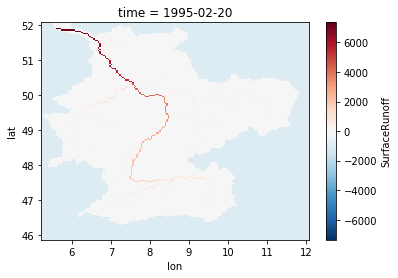

In [16]:
#Plot variable map of time step 50
array = ds[variable].isel(time= 50)
array.plot()

In [17]:
#Get timeseries data of a variabel from xarray Dataset for a given cell
timeseries = ds[variable].sel(lat= 51.8325, lon=6.0955, method= 'nearest')

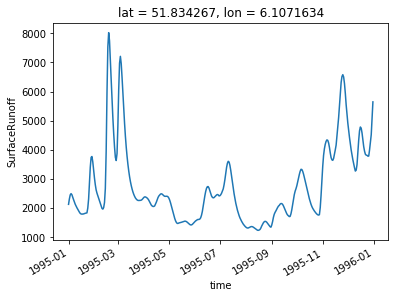

In [18]:
#Timeseries plot of selected variable
timeseries.plot()

In [19]:
#Create dataframe with time, simulated and observed values
#Note: order of columns needs to be time, sim, obs for the hydrostats package
timeseries = ds[variable].sel(lat= 51.8325, lon=6.0955, method= 'nearest')

sim = timeseries.to_dataframe()

obs = pd.read_csv(r"C:\Users\jerom\Desktop\wflow\examples\grdc.csv", sep=';')
obs['date'] = pd.to_datetime(obs['date'])
obs['date'] = obs['date'].dt.strftime('%Y-%m-%d')

pd.to_datetime(obs['date'])
obs.set_index('date', inplace=True)

val = sim.merge(obs, left_index=True, right_index=True, how='inner')
val.columns = ['sim', 'lat', 'lon', 'obs']
val = val.drop(columns=['lat', 'lon'])

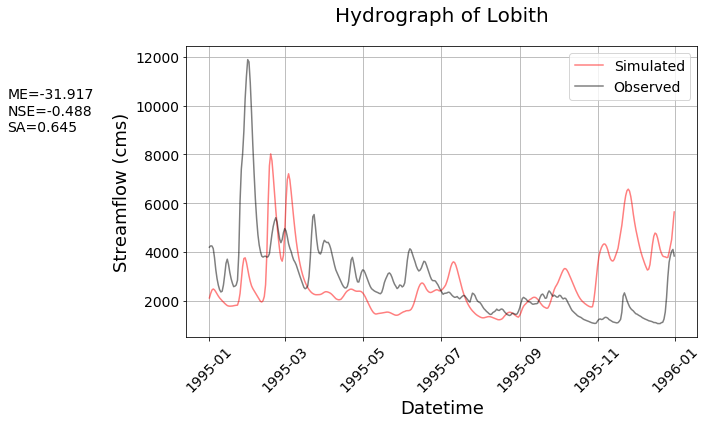

In [20]:
#Plot hydrograph for simulated and observed values and calculate statistics

hv.plot(val,
      title='Hydrograph of Lobith',
      linestyles=['r-', 'k-'],
      legend=('Simulated', 'Observed'),
      labels=['Datetime', 'Streamflow (cms)'],
      metrics=['ME', 'NSE', 'SA'],
      grid=True)
plt.show()

In [21]:
#Seperate statistics using hydrostats
sim = val['sim']
obs = val['obs']
  
nse = he.nse(sim, obs)
pearson_r = he.pearson_r(sim, obs)

print nse
print pearson_r

-0.48797051042199513
0.1150378044320771
